# Hamiltonian NN (HNN) in (q, p) space

- Original code for (q, v) space from Y. Chen

- Modified and adapted to (q, p) space by Jae Hoon (Daniel) Lee

In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp


seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True

In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/hnn_target_ms_qp_sep_sc.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/hnn_input_ms_qp_sep_sc.csv", header=None, dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
N = 2
O = np.zeros((N,N))
Id = np.eye(N)
S = np.vstack([np.hstack([O,Id]),np.hstack([-Id,O])])
St = torch.tensor(-S, dtype=torch.float32).to(device)
class MLP(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(MLP,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x
  
  def grad(self,x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      hamiltonian = self(x)
      gradient = torch.autograd.grad(hamiltonian.sum(),x,create_graph=True,retain_graph=True)
    return torch.matmul(gradient[0],St)

  def fvec(self,t,x):
    return self.grad(x)

In [5]:
import time
input_size = 4
output_size = 1
hidden_size = 200
num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range(num_trials):
  mynet = MLP(input_size,hidden_size,output_size).to(device)
  num_epochs = 2000

  criterion = nn.MSELoss()

  optimizer = optim.Adam(params=mynet.parameters(),lr=0.0001)

  history_loss = []
  history_eval = []
  history_acc = []

  cnt = 0
  startt = time.time()
  for epoch in range(num_epochs):
    mynet.train()

    total_loss = 0.0
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = mynet.grad(data.to(device))

      loss = criterion(output,target.to(device))
      loss.backward()
      optimizer.step()

      total_loss = total_loss+loss.cpu().item()
      cnt = cnt + 1
    total_loss = total_loss/cnt

    num_correct = 0
    num_data = 0
    mynet.eval()
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(test_loader):
      output = mynet.grad(data.to(device))
      eval_loss = eval_loss+criterion(output,target.to(device)).cpu().item()
      cnt = cnt + 1
    eval_loss = eval_loss/cnt
  
    history_loss.append(total_loss)
    history_eval.append(eval_loss)

  
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  path = "./model/danieljh_hnn_ms_qp_sep_sc_lr_{}".format(trial)
  torch.save(mynet.state_dict(), path)
  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)

print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))


2000/2000 training loss:0.000131546501415869,evaluation loss:0.00013212822195782792
2000/2000 training loss:0.0001315803188845166,evaluation loss:0.00013176414868212304
2000/2000 training loss:0.00013185269817768132,evaluation loss:0.0001314812820055522
2000/2000 training loss:0.00013133114534866764,evaluation loss:0.00013238477040431463
2000/2000 training loss:0.00013121449164827937,evaluation loss:0.0001314682074735174
2000/2000 training loss:0.00013187050863052718,evaluation loss:0.0001314890138019109
2000/2000 training loss:0.00013110945646985784,evaluation loss:0.0001309713003138313
2000/2000 training loss:0.00013280198563734303,evaluation loss:0.0001324011740507558
2000/2000 training loss:0.00013149783399057924,evaluation loss:0.00013154260705050547
2000/2000 training loss:0.00013107843751640756,evaluation loss:0.0001311033181991661
train_loss:0.00013158833777197288, std: 4.824611813693416e-07
test_loss:0.00013167340439395047, std: 4.68919699829627e-07
computation_time:787.389100

In [6]:
A = pd.read_csv("./data/hnn_A_ms_qp_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/hnn_B_ms_qp_sep_sc.csv", header=None, dtype=np.float32)
A = np.asmatrix(A)
B = np.asmatrix(B)

HNN x0 (q, p): (0.91369884, 0.76173912, 0.7811432, 0.89894044)
(0.91369884, 0.76173912, 0.7811432, 0.89894044)


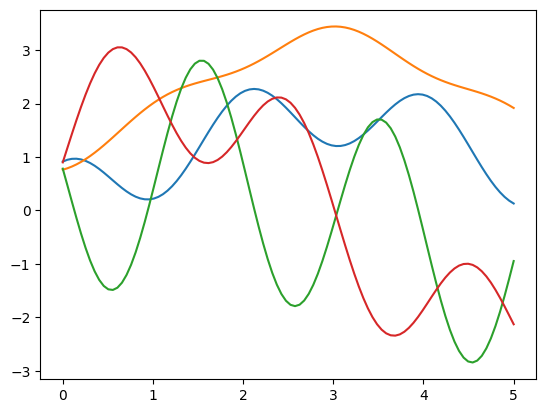

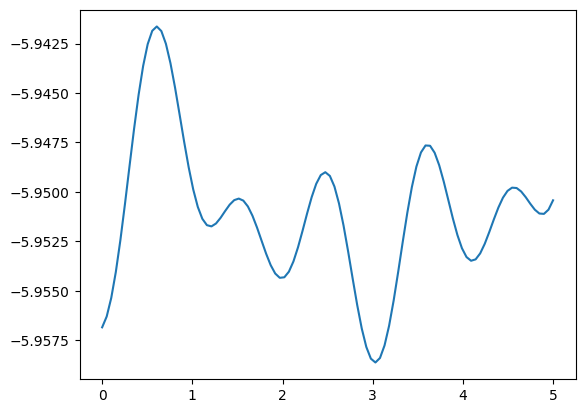

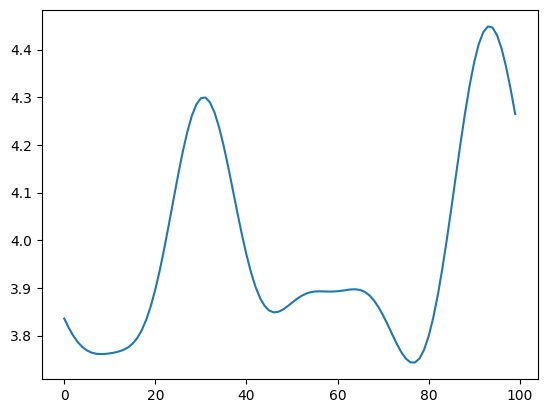

In [ ]:
# simulation
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0 

trial = num_trials - 1

input_size = 4
output_size = 1
hidden_size = 200
mynet = MLP(input_size,hidden_size,output_size).to('cpu')
mynet.load_state_dict(torch.load("./model/danieljh_hnn_ms_qp_sep_sc_lr_{}".format(trial), map_location="cpu"))
mynet.eval()
teval = torch.linspace(0.0,5.0,100)

# # initial values (q1, q2, v1, v2 order)
# state_init = []
# for i in range(1):
#   # Y. Chen's code setting
#   s = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
#   state_init.append(s)

# --- x0 modification: (q1, q2, v1, v2) -> (q1, q2, p1, p2) ---
q1_0, q2_0, v1_0, v2_0 = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
p1_0, p2_0 = m1*v1_0, m2*v2_0
x0 = (q1_0, q2_0, p1_0, p2_0) # HNN's (q, p) input compliant modification
print(f"HNN x0 (q, p): {x0}")
# -----------------------------------------------------

print(x0)
dt = teval[1]-teval[0]
St = torch.tensor(-S, dtype=torch.float32)
teval = teval.detach().cpu().numpy()
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
mynet.eval()
mynet.cpu()

def fvec_np(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  output = mynet.grad(x).squeeze(0)
  output = torch.matmul(A, output)
  output = output.squeeze(0)    
  return output.detach().cpu().numpy()

res = scipy.integrate.odeint(fvec_np,x0,teval)

plt.plot(teval,res[:,0])
plt.plot(teval,res[:,1])
plt.plot(teval,res[:,2])
plt.plot(teval,res[:,3])
plt.show()

def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = mynet.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()

net_energy = net_energy(res, teval).reshape((100))
plt.plot(teval,net_energy)
plt.show()
  
# H(q, p) formula application
# Kinetic Energy T(p)
kinetic_energy = np.square(res[:, 2]) / (2 * m1) + np.square(res[:, 3]) / (2 * m2)

# Potential Energy V(q)
potential_energy = k1 * np.square((res[:, 0] - l1)) / 2 + k2 * np.square((res[:, 1] - res[:, 0] - l2)) / 2

# Total Hamiltonian H = T + V
energy = kinetic_energy + potential_energy
  
plt.plot(energy)
plt.show()


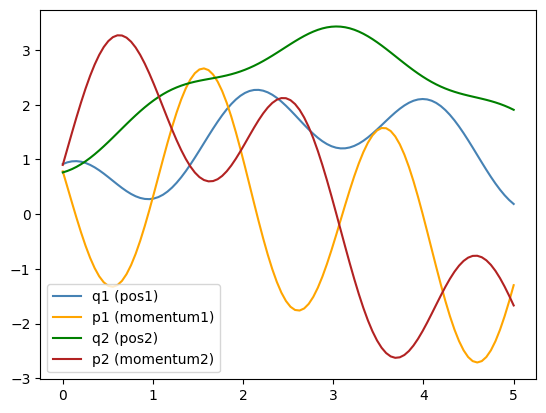

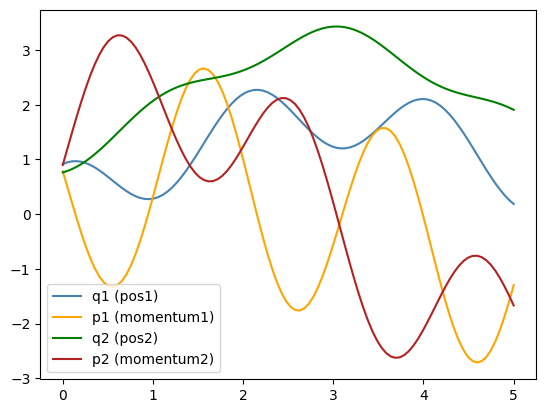

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp as solver 

# Ground truth
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0

# equations of motion (q, v space)
def func(t, state):
  """
  ODE of the serial mass-spring system (q, v space)
  state = [q1, q2, v1, v2]
  dvdt = [v1, v2, a1, a2]
  """
  dvdt = np.zeros_like(state)
  
  # dq/dt = v
  dvdt[0] = state[2] # v1
  dvdt[1] = state[3] # v2
  
  # dv/dt = a (acceleration computation)
  # a1 = (-k1*(q1-l1)+k2*(q2-q1-l2))/m1
  dvdt[2] = (-k1*(state[0]-l1)+k2*(state[1]-state[0]-l2))/m1
  # a2 = -k2*(q2-q1-l2)/m2
  dvdt[3] = -k2*(state[1]-state[0]-l2)/m2
  
  return dvdt

# the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval-t_eval

# initial value (q1, q2, v1, v2 order)
state_init = []
for i in range(1):
  # initial value in Y. Chen's
  s = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  state_init.append(s)

# Trajectory computation
for i in range(1):
  sol = solver(func, [0, tend], state_init[i], t_eval=t_eval)
  tval = sol['t']
  
# (q, v) trajectory
true_x_qv = sol['y'].T
q1 = sol['y'][0, :]
q2 = sol['y'][1, :]
v1 = sol['y'][2, :]
v2 = sol['y'][3, :]
  
# For HNN, (v, q) have to be converted to (q, p)
p1 = m1 * v1
p2 = m2 * v2

# plot: in (q, p)
plt.plot(tval, q1, 'steelblue', label='q1 (pos1)')
plt.plot(tval, p1, 'orange', label='p1 (momentum1)')
plt.plot(tval, q2, 'g', label='q2 (pos2)')
plt.plot(tval, p2, 'firebrick', label='p2 (momentum2)')
plt.legend()
plt.show()


# initial values (q1, q2, p1, p2 order)
state_qp_init = []
for i in range(1):
  # multiplied by mass-matrix for the initial value of Y. Chen's.
  s = (0.91369884, 0.76173912, 0.7811432 * m1,  0.44947022 * m2)
  state_qp_init.append(s)

# When equations of motion in (q, v space) is used for (q, p) input
def func_qp(t, state_qp):
  """
  ODE of serial mass-spring system (q, v space)
  state = [q1, q2, p1, p2]
  dvdt = [v1, v2, p1[dot], p2[dot]]
  """
  dvdt = np.zeros_like(state_qp)
  
  # dq/dt = v
  dvdt[0] = state_qp[2] / m1 # v1 from p1
  dvdt[1] = state_qp[3] / m2 # v2 from p2
  
  # dv/dt = a (acceleration computation)
  # a1 = (-k1*(q1-l1)+k2*(q2-q1-l2))/m1
  dvdt[2] = -k1*(state_qp[0]-l1)+k2*(state_qp[1]-state_qp[0]-l2)
  # a2 = -k2*(q2-q1-l2)/m2
  dvdt[3] = -k2*(state_qp[1]-state_qp[0]-l2)
  
  return dvdt

# Trajectory compution
for i in range(1):
  sol_qp= solver(func_qp, [0, tend], state_qp_init[i], t_eval=t_eval)
  tval = sol['t']
  
# (q, p) trajectory
true_x_qp = sol_qp['y'].T
  

# plot in (q, p)
plt.plot(tval, true_x_qp[:,0], 'steelblue', label='q1 (pos1)')
plt.plot(tval, true_x_qp[:,2], 'orange', label='p1 (momentum1)')
plt.plot(tval, true_x_qp[:,1], 'g', label='q2 (pos2)')
plt.plot(tval, true_x_qp[:,3], 'firebrick', label='p2 (momentum2)')
plt.legend()
plt.show()



In [ ]:
def Hamiltonian_qv(orbits_qv):
    """
    Computes the total energy (Hamiltonian) of the system 
    based on the given state vector (q1, q2, v1, v2) 
    """
    q1 = orbits_qv[:,0]
    q2 = orbits_qv[:,1]
    v1 = orbits_qv[:,2]
    v2 = orbits_qv[:,3]
    
    # Kinetic Energy: K = 0.5 * m * v^2
    kinetic = 0.5 * (m1 * (v1**2) + m2 * (v2**2))
    
    # Potential Energy: V = 0.5 * k * x^2
    potential = 0.5 * (k1 * (q1-l1)**2 + k2 * (q2-q1-l2)**2)

    return (kinetic + potential)

def Hamiltonian_qp(orbits_qp):
    """
    Computes the total energy (Hamiltonian) of the system
    based on the given state vector (q1, q2, p1, p2)
    """
    q1 = orbits_qp[:,0]
    q2 = orbits_qp[:,1]
    p1 = orbits_qp[:,2]
    p2 = orbits_qp[:,3]
    
    # Kinetic Energy: K = 0.5 * m * v^2
    kinetic = 0.5 * ((p1**2) / m1  + (p2**2) / m2)
    
    # Potential Energy: V = 0.5 * k * x^2
    potential = 0.5 * (k1 * (q1-l1)**2 + k2 * (q2-q1-l2)**2)

    return (kinetic + potential)


HNN x0 (q, p): (0.91369884, 0.76173912, 0.7811432, 0.89894044)
(0.91369884, 0.76173912, 0.7811432, 0.89894044)


/tmp/ipykernel_208645/3362416579.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
/tmp/ipykernel_208645/3362416579.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = torch.tensor(B, dtype=torch.float32)


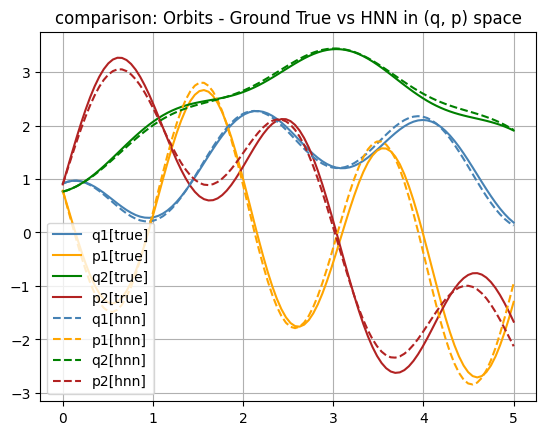

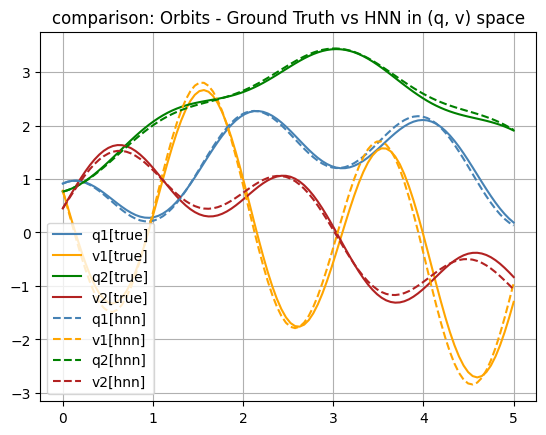

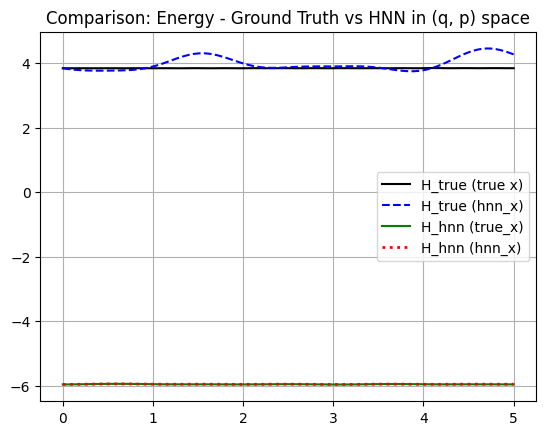

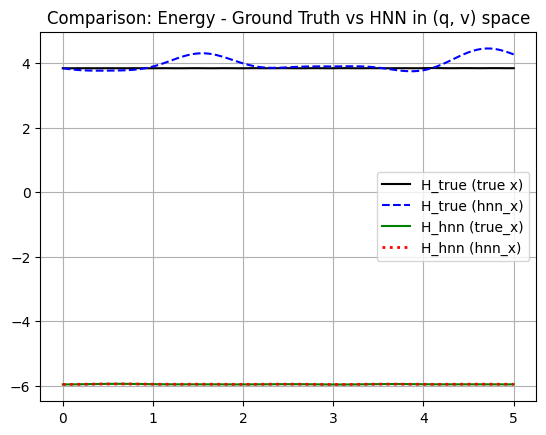

In [ ]:
# --- x0 modification: (q1, q2, v1, v2) -> (q1, q2, p1, p2) ---
q1_0, q2_0, v1_0, v2_0 = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
p1_0, p2_0 = m1*v1_0, m2*v2_0
x0 = (q1_0, q2_0, p1_0, p2_0) # HNN's (q, p) input compliant modification
print(f"HNN x0 (q, p): {x0}")
# -----------------------------------------------------

print(x0)
dt = teval[1]-teval[0]
St = torch.tensor(-S, dtype=torch.float32)
#teval = teval.detach().cpu().numpy()
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
mynet.eval()
mynet.cpu()

def fvec_np(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  output = mynet.grad(x).squeeze(0)
  output = torch.matmul(A, output)
  output = output.squeeze(0)    
  return output.detach().cpu().numpy()

res = scipy.integrate.odeint(fvec_np,x0,teval)

plt.title("comparison: Orbits - Ground True vs HNN in (q, p) space")
plt.plot(tval, true_x_qp[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x_qp[:,2], 'orange', label='p1[true]', linestyle='-')
plt.plot(tval, true_x_qp[:,1], 'g', label='q2[true]', linestyle='-')
plt.plot(tval, true_x_qp[:,3], 'firebrick', label='p2[true]', linestyle='-')
plt.plot(tval, res[:,0], 'steelblue', label='q1[hnn]', linestyle='--')
plt.plot(tval, res[:,2], 'orange', label='p1[hnn]', linestyle='--')
plt.plot(tval, res[:,1], 'g', label='q2[hnn]', linestyle='--')
plt.plot(tval, res[:,3], 'firebrick', label='p2[hnn]',linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

plt.title("comparison: Orbits - Ground Truth vs HNN in (q, v) space")
plt.plot(tval, true_x_qv[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x_qv[:,2], 'orange', label='v1[true]', linestyle='-')
plt.plot(tval, true_x_qv[:,1], 'g', label='q2[true]', linestyle='-')
plt.plot(tval, true_x_qv[:,3], 'firebrick', label='v2[true]', linestyle='-')
plt.plot(tval, res[:,0], 'steelblue', label='q1[hnn]', linestyle='--')
plt.plot(tval, res[:,2]/m1, 'orange', label='v1[hnn]', linestyle='--')
plt.plot(tval, res[:,1], 'g', label='q2[hnn]', linestyle='--')
plt.plot(tval, res[:,3]/m2, 'firebrick', label='v2[hnn]',linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = mynet.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()

hnn_x_qp = res.copy()

hnn_energy_hnn_x_qp = net_energy(hnn_x_qp, teval).reshape((100))
hnn_energy_true_x_qp = net_energy(true_x_qp, teval).reshape((100))

true_energy_true_x_qp = Hamiltonian_qp(true_x_qp)
true_energy_hnn_x_qp = Hamiltonian_qp(hnn_x_qp)

plt.title("Comparison: Energy - Ground Truth vs HNN in (q, p) space")
plt.plot(teval, true_energy_true_x_qp, label='H_true (true x)', color='k', linestyle='-')
plt.plot(teval, true_energy_hnn_x_qp, label='H_true (hnn_x)', color='b',linestyle='--')
plt.plot(teval, hnn_energy_true_x_qp, label='H_hnn (true_x)', color='g', linestyle='-', lw=1.5)
plt.plot(teval, hnn_energy_hnn_x_qp, label='H_hnn (hnn_x)', color='r', linestyle=':', lw=2)
plt.grid(True)
plt.legend()  
         
plt.show()

hnn_energy_hnn_x_qv = net_energy(res, teval).reshape((100))
temp = true_x_qv.copy()
temp[:,2] = temp[:,2] * m1
temp[:,3] = temp[:,3] * m2
hnn_energy_true_x_qv = net_energy(temp, teval).reshape((100))

temp = hnn_x_qp.copy()
temp[:,2] = temp[:,2] / m1
temp[:,3] = temp[:,3] / m2
true_energy_hnn_x_qv = Hamiltonian_qv(temp)
true_energy_true_x_qv = Hamiltonian_qv(true_x_qv)


plt.title("Comparison: Energy - Ground Truth vs HNN in (q, v) space")
plt.plot(teval, true_energy_true_x_qv, label='H_true (true x)', color='k', linestyle='-')
plt.plot(teval, true_energy_hnn_x_qv, label='H_true (hnn_x)', color='b',linestyle='--')
plt.plot(teval, hnn_energy_true_x_qv, label='H_hnn (true_x)', color='g', linestyle='-', lw=1.5)
plt.plot(teval, hnn_energy_hnn_x_qv, label='H_hnn (hnn_x)', color='r', linestyle=':', lw=2)
plt.grid(True)
plt.legend()  
         
plt.show()